<a href="https://colab.research.google.com/github/pakkei1212/SMU_AML_PROJ/blob/main/Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 15.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import optuna

from re import VERBOSE
from sklearn.metrics import (
    recall_score, classification_report, roc_auc_score, roc_curve
)
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.base import clone
from sklearn.inspection import permutation_importance
import joblib
import json
import tqdm
import shap

from hotel_preprocessing_orig import clean_data, extract_features, drop_columns, XYPreprocessor

RANDOM_STATE = 2025
VERBOSE = 2

In [3]:
raw_hotel_data = pd.read_csv("hotel_bookings.csv")
hotel_data = raw_hotel_data.copy()

# Combine year, month, and day columns into a single datetime column
hotel_data['arrival_date'] = pd.to_datetime(
    hotel_data['arrival_date_year'].astype(str) + '-' +
    hotel_data['arrival_date_month'] + '-' +
    hotel_data['arrival_date_day_of_month'].astype(str),
    format='%Y-%B-%d'  # Ensure proper month name parsing
)

# Determine the latest arrival date
last_date = hotel_data['arrival_date'].max()

# Define the cutoff date for the last 3 months
cutoff_date = last_date - pd.DateOffset(months=3)

# Split by cutoff date
test_data = hotel_data[hotel_data['arrival_date'] > cutoff_date].reset_index(drop=True)
train_val_data = hotel_data[hotel_data['arrival_date'] <= cutoff_date].reset_index(drop=True)

# Separate raw features and labels
X_train_val_raw = train_val_data.drop(columns=['is_canceled'])
y_train_val_raw = train_val_data['is_canceled'].astype(int)

X_test_raw = test_data.drop(columns=['is_canceled'])
y_test_raw = test_data['is_canceled'].astype(int)

# Preprocess train_val once, then split into folds
preprocessor = XYPreprocessor()
X_train_val, y_train_val = preprocessor.fit_transform(X_train_val_raw, y_train_val_raw)

# Transform test set using the same preprocessor
X_test, y_test = preprocessor.transform(X_test_raw, y_test_raw)

In [4]:
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 20),  # allow deeper trees
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),  # prevent overfitting
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),    # prevent small noisy leaves
        "ccp_alpha": trial.suggest_float("ccp_alpha", 0.0001, 0.02, log=True)  # fine pruning range, log scale
    }

    aucs = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, val_idx in skf.split(X_train_val, y_train_val):
        X_train = X_train_val.iloc[train_idx]
        X_val = X_train_val.iloc[val_idx]
        y_train = y_train_val.iloc[train_idx]
        y_val = y_train_val.iloc[val_idx]

        model = DecisionTreeClassifier(**params, random_state=42)
        model.fit(X_train, y_train)
        y_val_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_val_pred)
        aucs.append(auc)

    return np.mean(aucs)

# Run optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)  # increase trials for better coverage

print("Best hyperparameters:", study.best_params)


[I 2025-06-18 17:18:37,462] A new study created in memory with name: no-name-a3396d27-9fe5-4340-ad56-ca56a857c646
[I 2025-06-18 17:18:50,173] Trial 0 finished with value: 0.8415836718017171 and parameters: {'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 5, 'ccp_alpha': 0.00317963045114294}. Best is trial 0 with value: 0.8415836718017171.
[I 2025-06-18 17:18:53,320] Trial 1 finished with value: 0.8082839903471493 and parameters: {'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 6, 'ccp_alpha': 0.004359823811813634}. Best is trial 0 with value: 0.8415836718017171.
[I 2025-06-18 17:18:57,412] Trial 2 finished with value: 0.8341349619914988 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 3, 'ccp_alpha': 0.0035161277966241247}. Best is trial 0 with value: 0.8415836718017171.
[I 2025-06-18 17:18:58,765] Trial 3 finished with value: 0.7475721627867765 and parameters: {'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 5, 'ccp_alp

Best hyperparameters: {'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 3, 'ccp_alpha': 0.00010080445289884022}


In [9]:
# Final training on full training + validation data
best_params = study.best_params
final_model = DecisionTreeClassifier(**best_params, random_state=42)
final_model.fit(X_train_val, y_train_val)

# Predict on test set (probabilities and binary class)
y_test_proba = final_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= 0.5).astype(int)  # threshold at 0.5

# Compute metrics
test_auc = roc_auc_score(y_test, y_test_proba)
test_recall = recall_score(y_test, y_test_pred)
# Print classification report
print(classification_report(y_test, y_test_pred))

print("Final Test AUC:", test_auc)
print("Final Test Recall:", test_recall)

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      8512
           1       0.67      0.70      0.69      4649

    accuracy                           0.77     13161
   macro avg       0.75      0.76      0.76     13161
weighted avg       0.78      0.77      0.78     13161

Final Test AUC: 0.849062290762667
Final Test Recall: 0.701871370187137


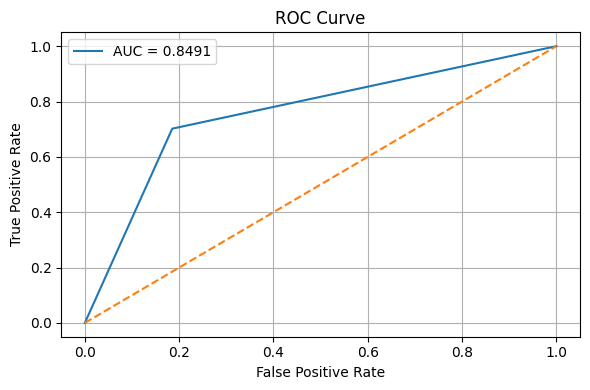

In [6]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {test_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

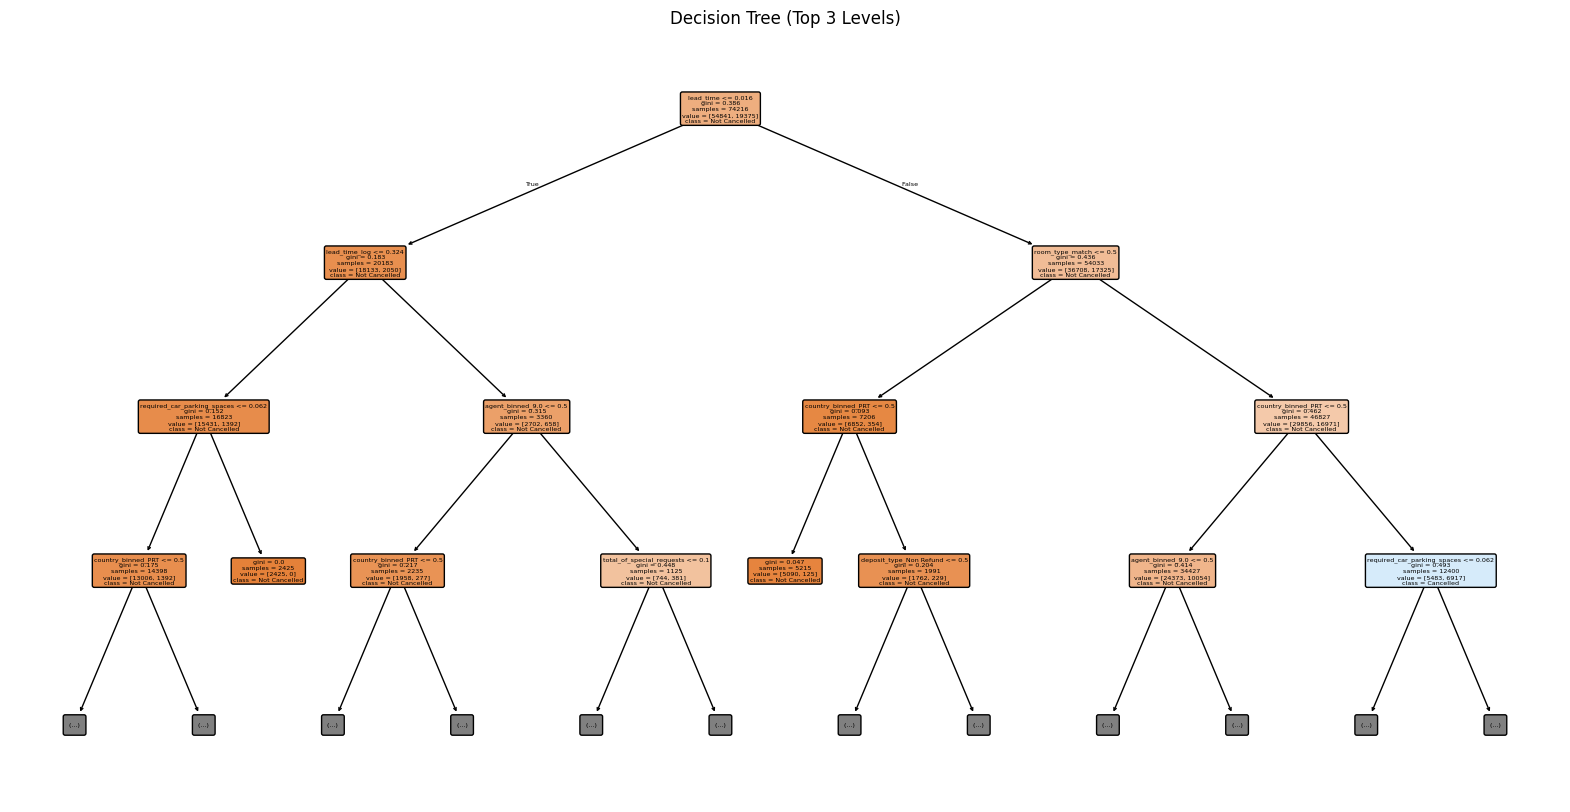

In [7]:
# Visualize the tree
levels_for_viz = 3
plt.figure(figsize=(20, 10))
plot_tree(final_model, feature_names=X_train_val.columns, class_names=["Not Cancelled", "Cancelled"],
          filled=True, rounded=True, max_depth=levels_for_viz)  # keep short for readability
plt.title(f"Decision Tree (Top {levels_for_viz} Levels)")
plt.show()

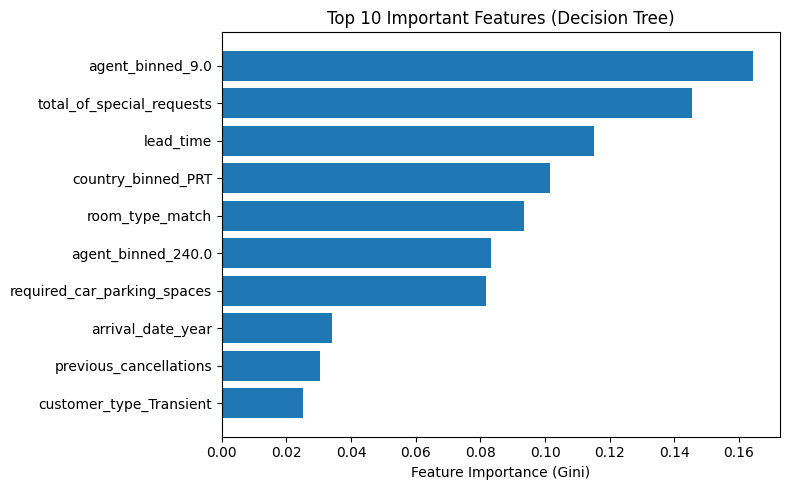

In [8]:
# Show top 10 feature importances
importances = final_model.feature_importances_
features = X_train_val.columns
top_idx = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(8, 5))
plt.barh(range(10), importances[top_idx][::-1])
plt.yticks(range(10), [features[i] for i in top_idx][::-1])
plt.xlabel("Feature Importance (Gini)")
plt.title("Top 10 Important Features (Decision Tree)")
plt.tight_layout()
plt.show()


In [11]:
feature_importances = pd.DataFrame({
    'feature': X_train_val.columns,
    'importance': final_model.feature_importances_
}).sort_values(by='importance', ascending=False)

print(feature_importances)

                      feature  importance
94           agent_binned_9.0    0.164443
15  total_of_special_requests    0.145447
0                   lead_time    0.114985
92         country_binned_PRT    0.101597
21            room_type_match    0.093577
..                        ...         ...
87         country_binned_GBR    0.000000
86         country_binned_FRA    0.000000
89         country_binned_ITA    0.000000
88         country_binned_IRL    0.000000
93           agent_binned_7.0    0.000000

[99 rows x 2 columns]
